In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
a = np.array([[1, 2], [3, 4]])
print(a.shape)
a = np.expand_dims(a, axis=-1)
print(a.shape)
print(a)

(2, 2)
(2, 2, 1)
[[[1]
  [2]]

 [[3]
  [4]]]


In [5]:
train_data = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_data, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 6ms/step - loss: 73.0340 - mae: 73.5333 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 65.8473 - mae: 66.3473 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 58.4370 - mae: 58.9370 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 50.6531 - mae: 51.1531 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 41.2781 - mae: 41.7781 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 31.1241 - mae: 31.6240 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 23.1006 - mae: 23.5953 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 17.9297 - mae: 18.4206 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 14.8685 - mae: 15.3582 

(1e-08, 0.0001, 0.0, 30.0)

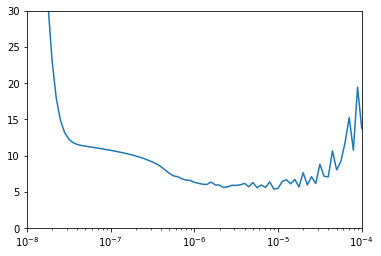

In [6]:
plt.semilogx(history.history["lr"], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [33]:
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=4e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 11ms/step - loss: 37.0684 - mae: 37.5657
Epoch 2/400
8/8 [==============================] - 0s 7ms/step - loss: 22.7054 - mae: 23.2013
Epoch 3/400
8/8 [==============================] - 0s 6ms/step - loss: 18.6552 - mae: 19.1523
Epoch 4/400
8/8 [==============================] - 0s 6ms/step - loss: 14.5009 - mae: 14.9918
Epoch 5/400
8/8 [==============================] - 0s 6ms/step - loss: 13.7978 - mae: 14.2924
Epoch 6/400
8/8 [==============================] - 0s 6ms/step - loss: 13.3265 - mae: 13.8196
Epoch 7/400
8/8 [==============================] - 0s 5ms/step - loss: 14.1155 - mae: 14.6086
Epoch 8/400
8/8 [==============================] - 0s 6ms/step - loss: 11.0924 - mae: 11.5803
Epoch 9/400
8/8 [==============================] - 0s 6ms/step - loss: 11.9287 - mae: 12.4177
Epoch 10/400
8/8 [==============================] - 0s 6ms/step - loss: 9.5694 - mae: 10.0601
Epoch 11/400
8/8 [==============================] - 0s 6ms/

8/8 [==============================] - 0s 7ms/step - loss: 4.8199 - mae: 5.2995
Epoch 176/400
8/8 [==============================] - 0s 6ms/step - loss: 5.2894 - mae: 5.7698
Epoch 177/400
8/8 [==============================] - 0s 6ms/step - loss: 5.4434 - mae: 5.9244
Epoch 178/400
8/8 [==============================] - 0s 7ms/step - loss: 5.3702 - mae: 5.8508
Epoch 179/400
8/8 [==============================] - 0s 7ms/step - loss: 4.9248 - mae: 5.4032
Epoch 180/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6688 - mae: 5.1412
Epoch 181/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6154 - mae: 5.0907
Epoch 182/400
8/8 [==============================] - 0s 6ms/step - loss: 4.8195 - mae: 5.3015
Epoch 183/400
8/8 [==============================] - 0s 6ms/step - loss: 5.3926 - mae: 5.8705
Epoch 184/400
8/8 [==============================] - 0s 7ms/step - loss: 6.0881 - mae: 6.5730
Epoch 185/400
8/8 [==============================] - 0s 7ms/step - loss: 6

8/8 [==============================] - 0s 7ms/step - loss: 4.9571 - mae: 5.4363
Epoch 350/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6926 - mae: 5.1700
Epoch 351/400
8/8 [==============================] - 0s 6ms/step - loss: 4.1203 - mae: 4.5913
Epoch 352/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3420 - mae: 4.8219
Epoch 353/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3295 - mae: 4.8090
Epoch 354/400
8/8 [==============================] - 0s 6ms/step - loss: 4.2572 - mae: 4.7353
Epoch 355/400
8/8 [==============================] - 0s 5ms/step - loss: 4.3262 - mae: 4.7995
Epoch 356/400
8/8 [==============================] - 0s 5ms/step - loss: 4.1155 - mae: 4.5834
Epoch 357/400
8/8 [==============================] - 0s 5ms/step - loss: 4.0027 - mae: 4.4751
Epoch 358/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3244 - mae: 4.7967
Epoch 359/400
8/8 [==============================] - 0s 6ms/step - loss: 4

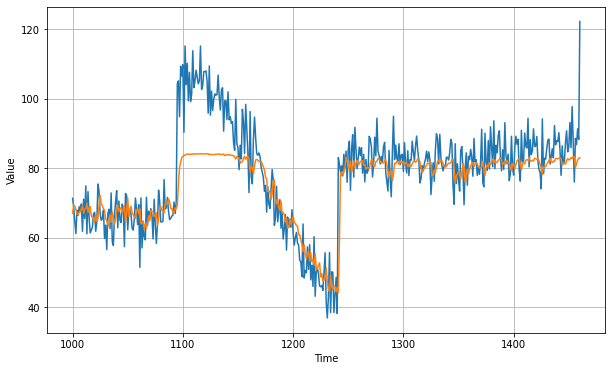

In [34]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [35]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.402644

<Figure size 432x288 with 0 Axes>

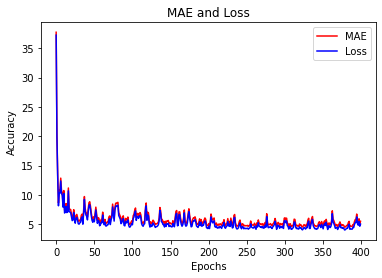

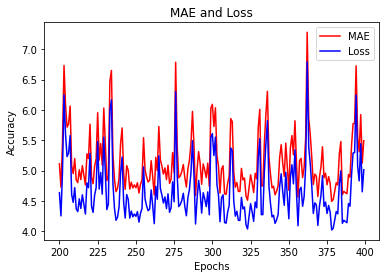

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["MAE", "Loss"])

plt.figure()

Epoch 1/100
31/31 [==============================] - 0s 6ms/step - loss: 30.6084 - mae: 31.1068 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 29.3719 - mae: 29.8714 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 27.8973 - mae: 28.3952 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 26.3486 - mae: 26.8445 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 24.7383 - mae: 25.2341 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 23.1331 - mae: 23.6289 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 21.5616 - mae: 22.0572 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 20.0995 - mae: 20.5933 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 18.7756 - mae: 19.2674 

Epoch 74/100
31/31 [==============================] - 0s 8ms/step - loss: 8.8167 - mae: 9.3041 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 7ms/step - loss: 7.7975 - mae: 8.2860 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 6ms/step - loss: 8.2735 - mae: 8.7659 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 7ms/step - loss: 6.7747 - mae: 7.2556 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 7ms/step - loss: 7.1591 - mae: 7.6431 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 6ms/step - loss: 6.9420 - mae: 7.4269 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 6ms/step - loss: 6.4100 - mae: 6.8938 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 8ms/step - loss: 7.1795 - mae: 7.6648 - lr: 1.0000e-04
Epoch 82/100
31/31 [==============================] - 0s 8ms/step - loss: 8.3151 - mae: 8.8031 - lr: 1.1

(1e-08, 0.0001, 0.0, 30.0)

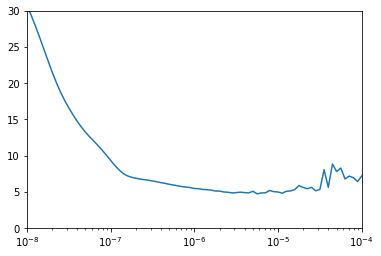

In [23]:
train_data = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_data, epochs=100, callbacks=[lr_schedule])
plt.semilogx(history.history["lr"], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [24]:
tf.keras.backend.clear_session()

train_data = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_data, epochs=300)


Epoch 1/300
8/8 [==============================] - 0s 45ms/step - loss: 27.7665 - mae: 28.2614
Epoch 2/300
8/8 [==============================] - 0s 29ms/step - loss: 16.7443 - mae: 17.2414
Epoch 3/300
8/8 [==============================] - 0s 35ms/step - loss: 11.2041 - mae: 11.6925
Epoch 4/300
8/8 [==============================] - 0s 39ms/step - loss: 8.7564 - mae: 9.2444
Epoch 5/300
8/8 [==============================] - 0s 38ms/step - loss: 7.3491 - mae: 7.8349
Epoch 6/300
8/8 [==============================] - 0s 35ms/step - loss: 6.2467 - mae: 6.7302
Epoch 7/300
8/8 [==============================] - 0s 33ms/step - loss: 6.1702 - mae: 6.6521
Epoch 8/300
8/8 [==============================] - 0s 31ms/step - loss: 5.6609 - mae: 6.1402
Epoch 9/300
8/8 [==============================] - 0s 39ms/step - loss: 5.8977 - mae: 6.3798
Epoch 10/300
8/8 [==============================] - 0s 38ms/step - loss: 5.6309 - mae: 6.1109
Epoch 11/300
8/8 [==============================] - 0s 39ms/ste

8/8 [==============================] - 0s 27ms/step - loss: 4.2196 - mae: 4.6932
Epoch 175/300
8/8 [==============================] - 0s 26ms/step - loss: 4.3048 - mae: 4.7812
Epoch 176/300
8/8 [==============================] - 0s 32ms/step - loss: 4.5420 - mae: 5.0182
Epoch 177/300
8/8 [==============================] - 0s 28ms/step - loss: 4.5205 - mae: 5.0029
Epoch 178/300
8/8 [==============================] - 0s 27ms/step - loss: 4.3398 - mae: 4.8146
Epoch 179/300
8/8 [==============================] - 0s 31ms/step - loss: 4.4509 - mae: 4.9277
Epoch 180/300
8/8 [==============================] - 0s 26ms/step - loss: 4.3858 - mae: 4.8603
Epoch 181/300
8/8 [==============================] - 0s 27ms/step - loss: 4.7849 - mae: 5.2620
Epoch 182/300
8/8 [==============================] - 0s 26ms/step - loss: 4.3958 - mae: 4.8735
Epoch 183/300
8/8 [==============================] - 0s 34ms/step - loss: 4.4720 - mae: 4.9477
Epoch 184/300
8/8 [==============================] - 0s 26ms/ste

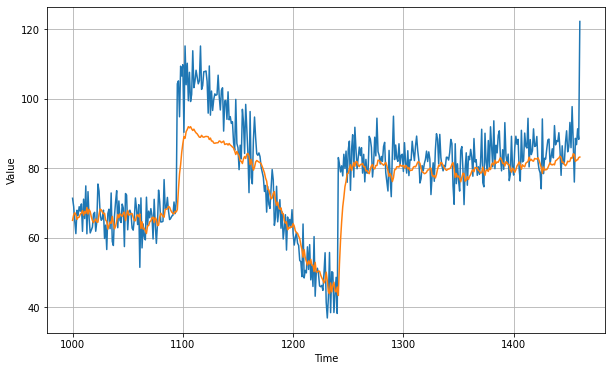

In [25]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.112808

<Figure size 432x288 with 0 Axes>

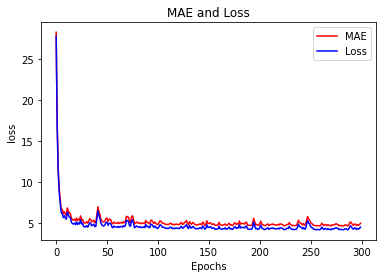

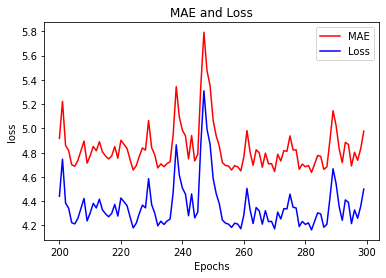

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["MAE", "Loss"])

plt.figure()